In [2]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [3]:
plt.style.use('ggplot')

In [4]:
coordinates_df = pd.read_csv('../data/coordinates.csv')
coordinates_df.head(2)

,cluster,station,X,Y,Z
0,1,1.1,-25.359,5.885,-6.684
1,1,1.2,-37.609,5.885,-6.684


In [5]:
def calculate_relative_times(theta_deg, phi_deg, coordinates_df):
    """
    Рассчитывает относительное время срабатывания станций для заданных углов θ и φ.

    Parameters:
    -----------
    theta_deg : float
        Зенитный угол (в градусах).
    phi_deg : float
        Азимутальный угол (в градусах).
    coordinates_df : pd.DataFrame
        Таблица с координатами станций, содержащая столбцы ['X', 'Y', 'Z'].

    Returns:
    --------
    list
        Список вида [(x1, y1, z1, t1), (x2, y2, z2, t2), ...] для всех станций,
        отсортированный по времени срабатывания.
    """
    C = 299792458e-9

    theta = np.radians(theta_deg)
    phi = np.radians(phi_deg)

    v = np.array([
        np.sin(theta) * np.cos(phi),
        np.sin(theta) * np.sin(phi),
        np.cos(theta)
    ])

    coordinates_df = coordinates_df.copy()
    coordinates_df["time"] = -(coordinates_df[["X", "Y", "Z"]].values @ v) / C

    coordinates_df["relative_time"] = coordinates_df["time"] - \
        coordinates_df["time"].min()

    sequence = [
        (row.X, row.Y, row.Z, row.relative_time)
        for row in coordinates_df.itertuples()
    ]
    return sequence

In [6]:
def generate_dataset(theta_list, phi_list, coordinates_df):
    dataset = []

    total_iterations = len(theta_list) * len(phi_list)
    with tqdm(total=total_iterations, desc="Generating dataset", unit="iteration") as pbar:
        for theta in theta_list:
            for phi in phi_list:
                sequence = calculate_relative_times(theta, phi, coordinates_df)

                relative_times = [row[3] for row in sequence]

                row_data = relative_times + [theta, phi]
                dataset.append(row_data)

                pbar.update(1)

    column_names = [
        f't_{i+1}' for i in range(len(coordinates_df))] + ['theta', 'phi']

    dataset_df = pd.DataFrame(dataset, columns=column_names)

    return dataset_df

In [7]:
def generate_dataset1(theta, phi, coordinates_df):
    dataset = []

    total_iterations = len(theta)
    with tqdm(total=total_iterations, desc="Generating dataset", unit="iteration") as pbar:
        for i in range(len(theta)):
            sequence = calculate_relative_times(
                theta[i], phi[i], coordinates_df)

            relative_times = [row[3] for row in sequence]

            row_data = relative_times + [theta[i], phi[i]]
            dataset.append(row_data)

            pbar.update(1)

    column_names = [
        f't_{i+1}' for i in range(len(coordinates_df))] + ['theta', 'phi']

    dataset_df = pd.DataFrame(dataset, columns=column_names)

    return dataset_df

In [45]:
phi_list = list(np.arange(182, 270, 0.01)) + list(np.arange(271, 360, 0.01))
theta_list = list(np.arange(1, 89.5, 0.01)) * 2

In [68]:
phi_list = list(np.arange(0, 354, 0.01))
theta_list = list(np.arange(1, 89.5, 0.01)) * 4

In [70]:
print(len(phi_list), len(theta_list))

35400 35400


In [71]:
my_dataset = generate_dataset1(theta_list, phi_list, coordinates_df)
my_dataset.head(5)

Generating dataset: 100%|██████████| 35400/35400 [01:08<00:00, 519.61iteration/s]


,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,...,t_29,t_30,t_31,t_32,t_33,t_34,t_35,t_36,theta,phi
0,24.145476,24.858610,24.858610,24.145476,24.145476,24.858610,24.858610,24.145476,0.0,0.777228,...,48.404568,50.356678,50.356678,46.903758,26.296637,27.105892,27.022514,26.129880,1.00,0.00
1,24.164010,24.884274,24.884409,24.164146,24.163687,24.883951,24.884087,24.163823,0.0,0.784999,...,48.383958,50.344912,50.345069,46.883310,26.315489,27.131668,27.048431,26.148874,1.01,0.01
2,24.182544,24.909939,24.910212,24.182818,24.181893,24.909287,24.909561,24.182166,0.0,0.792771,...,48.363352,50.333151,50.333468,46.862869,26.334347,27.157451,27.074359,26.167878,1.02,0.02
3,24.201079,24.935604,24.936019,24.201494,24.200092,24.934617,24.935031,24.200506,0.0,0.800542,...,48.342751,50.321394,50.321875,46.842436,26.353213,27.183240,27.100296,26.186891,1.03,0.03
4,24.219615,24.961270,24.961828,24.220173,24.218285,24.959941,24.960499,24.218843,0.0,0.808314,...,48.322155,50.309642,50.310289,46.822010,26.372086,27.209037,27.126243,26.205914,1.04,0.04


In [72]:
X_events = my_dataset.drop(columns=['theta', 'phi']).values
y_events = my_dataset[['theta', 'phi']].values

In [113]:
X_train, X_test, y_train, y_test = train_test_split(
    X_events, y_events, test_size=0.2, random_state=5)

In [114]:
train_data_theta = lgb.Dataset(X_train, label=y_train[:, 0])
train_data_phi = lgb.Dataset(X_train, label=y_train[:, 1])

In [115]:
params = {
    'objective': 'regression',
    'metric': 'l2',
    'num_threads': 10,
}

In [116]:
pbar = tqdm(total=50, desc="Training LightGBM", unit="iteration")


def tqdm_callback(env):
    pbar.update(1)

Training LightGBM: 200iteration [00:24,  8.17iteration/s] ion/s]


In [117]:
clf_theta = lgb.train(params,
                      train_data_theta,
                      num_boost_round=100,
                      valid_sets=[train_data_theta],
                      valid_names=['train'],
                      callbacks=[tqdm_callback])

Training LightGBM:  52%|█████▏    | 26/50 [00:00<00:00, 80.27iteration/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9180
[LightGBM] [Info] Number of data points in the train set: 28320, number of used features: 36
[LightGBM] [Info] Start training from score 45.115096


Training LightGBM: 97iteration [00:00, 225.85iteration/s]                

In [118]:
clf_phi = lgb.train(params,
                    train_data_phi,
                    num_boost_round=100,
                    valid_sets=[train_data_phi],
                    valid_names=['train'],
                    callbacks=[tqdm_callback])

Training LightGBM: 164iteration [00:00, 233.56iteration/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9180
[LightGBM] [Info] Number of data points in the train set: 28320, number of used features: 36
[LightGBM] [Info] Start training from score 176.661971


c:\Users\matsvei\.ai-navigator\conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\matsvei\.ai-navigator\conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


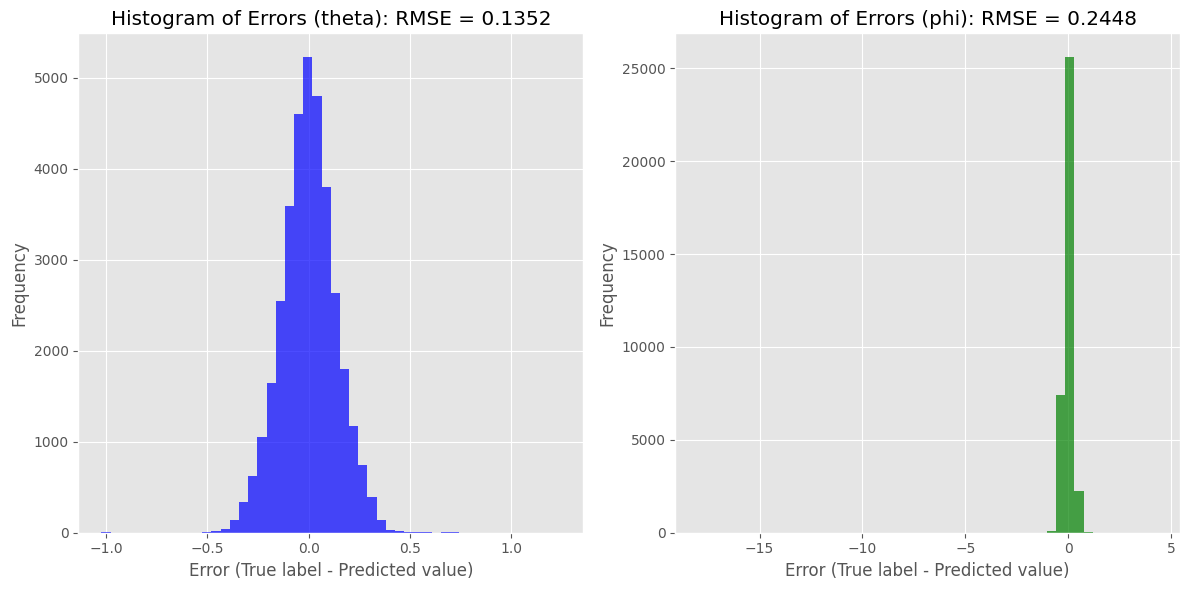

In [119]:
y_pred_theta = clf_theta.predict(
    X_events, num_iteration=clf_theta.best_iteration)
y_pred_phi = clf_phi.predict(X_events, num_iteration=clf_phi.best_iteration)

errors_theta = y_events[:, 0] - y_pred_theta
errors_phi = y_events[:, 1] - y_pred_phi


rmse_theta = mean_squared_error(y_events[:, 0], y_pred_theta, squared=False)
rmse_phi = mean_squared_error(y_events[:, 1], y_pred_phi, squared=False)


y_events_flat_theta = np.ravel(y_events[:, 0])
y_pred_flat_theta = np.ravel(y_pred_theta)

y_events_flat_phi = np.ravel(y_events[:, 1])
y_pred_flat_phi = np.ravel(y_pred_phi)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(errors_theta, bins=50, color='blue', alpha=0.7)
plt.title(f'Histogram of Errors (theta): RMSE = {rmse_theta:.4f}')
plt.xlabel('Error (True label - Predicted value)')
plt.ylabel('Frequency')
plt.grid(True)

# График для phi
plt.subplot(1, 2, 2)
plt.hist(errors_phi, bins=50, color='green', alpha=0.7)
plt.title(f'Histogram of Errors (phi): RMSE = {rmse_phi:.4f}')
plt.xlabel('Error (True label - Predicted value)')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()

In [120]:
max(errors_phi)

4.322687589887602

In [121]:
y_pred_theta = clf_theta.predict(
    X_test, num_iteration=clf_theta.best_iteration)

y_pred_phi = clf_phi.predict(
    X_test, num_iteration=clf_phi.best_iteration)

errors_theta = y_test[:, 0] - y_pred_theta
errors_phi = y_test[:, 1] - y_pred_phi

rmse_theta = mean_squared_error(y_test[:, 0], y_pred_theta, squared=False)


y_events_flat_theta = np.ravel(y_events[:, 0])
y_pred_flat_theta = np.ravel(y_pred_theta)

y_events_flat_phi = np.ravel(y_events[:, 1])
y_pred_flat_phi = np.ravel(y_pred_phi)

c:\Users\matsvei\.ai-navigator\conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


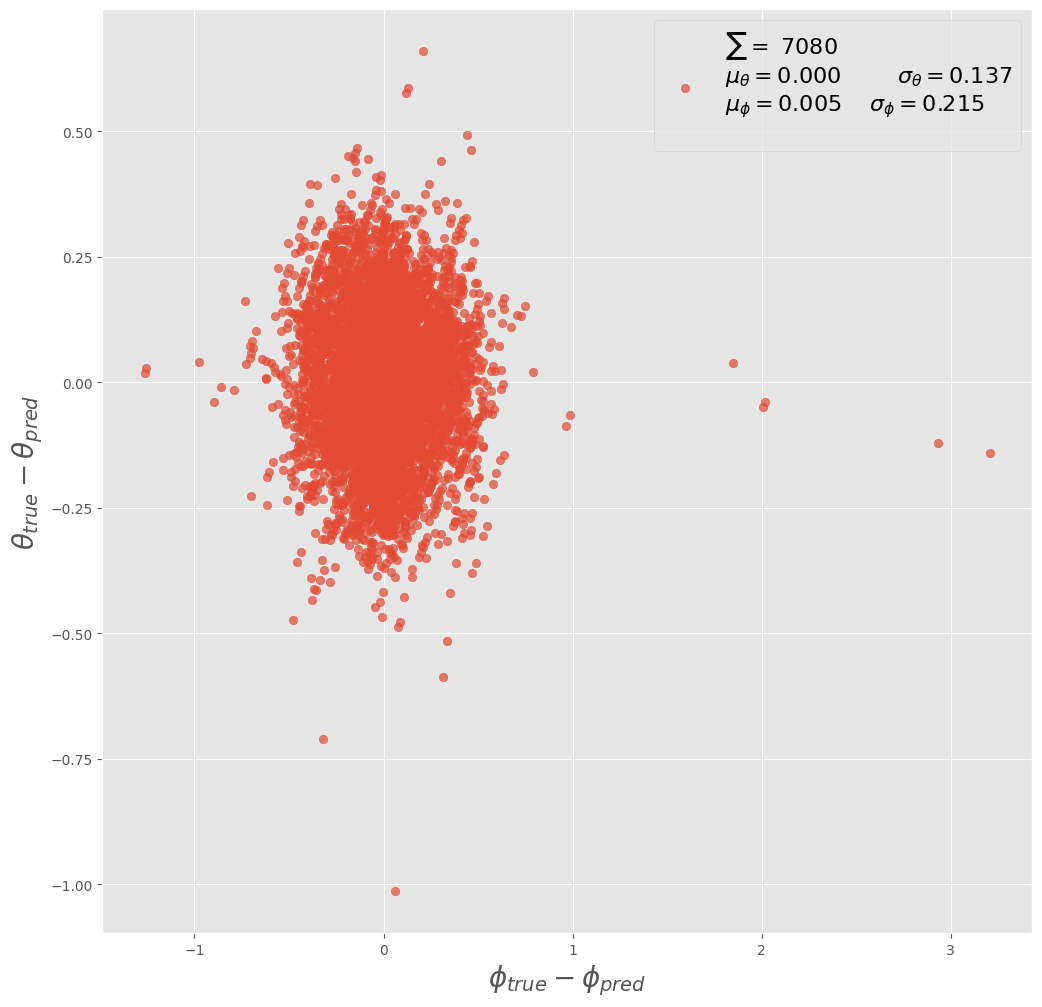

In [122]:

num_data = len(errors_theta)
mean_error_theta = np.mean(errors_theta)
mean_error_phi = np.mean(errors_phi)
std_error_theta = np.std(errors_theta)
std_error_phi = np.std(errors_phi)

label_text = (
    rf"$\sum = $ {num_data}" + '\n'
    rf"$\mu_{{\theta}} = {mean_error_theta:.3f}$        $\sigma_{{\theta}} = {
        std_error_theta:.3f}$" + '\n'
    rf"$\mu_{{\phi}} = {mean_error_phi:.3f}$    $\sigma_{{\phi}} = {
        std_error_phi:.3f}$" + '\n'
)

plt.figure(figsize=(12, 12))

plt.scatter(
    errors_phi,
    errors_theta,
    alpha=0.7,
    label=label_text
)

plt.xlabel(r'$\phi_{true} - \phi_{pred}$', fontsize=20)
plt.ylabel(r'$\theta_{true} - \theta_{pred}$', fontsize=20)

plt.grid(True)

plt.legend(fontsize=16, loc="best")

plt.savefig('plots/test_theta_vs_phi_diff.png')
plt.show()

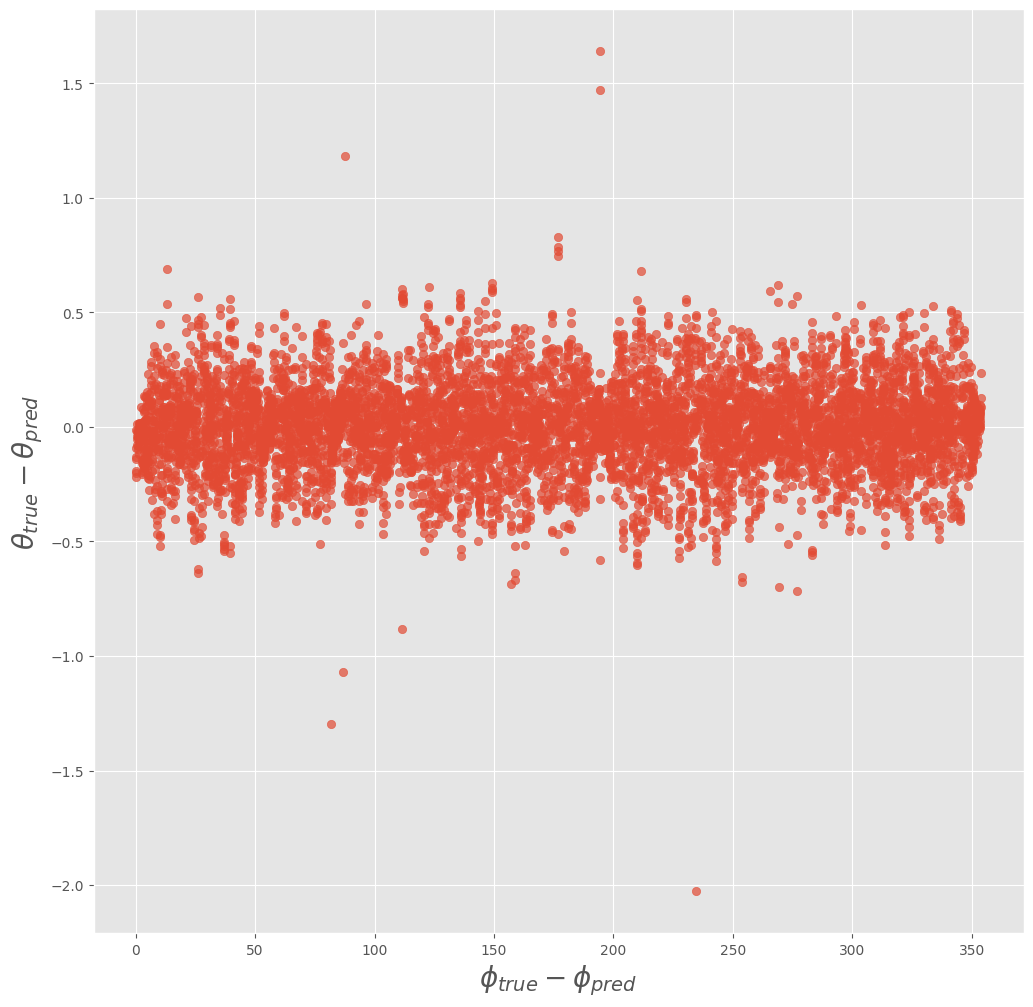

In [112]:
plt.figure(figsize=(12, 12))

plt.scatter(
    y_test[:, 1],
    errors_phi,
    alpha=0.7,
)

plt.xlabel(r'$\phi_{true} - \phi_{pred}$', fontsize=20)
plt.ylabel(r'$\theta_{true} - \theta_{pred}$', fontsize=20)

plt.grid(True)


plt.savefig('plots/test_theta_vs_phi_diff.png')
plt.show()

In [83]:
for i in range(len(y_pred_phi)):
    if abs(y_test[:, 1][i] - y_pred_phi[i]) > 2:
        print(y_test[:, 1][i], y_pred_phi[i])

Training LightGBM: 200iteration [00:14, 242.23iteration/s]